In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import os

# The local tensor metric :


the local tensor metric defines local metric and is used to calculate short lengths. For a given point $x$ on the sphere of radius $R$ and located with angles $\phi \in ]-\pi,\pi[$ (longitude) and $\theta \in ]-\pi/2,\pi/2[$ (latitude), the local metric tensor is 
$$
g_x = \left( \begin{array} &g _{\phi \phi} & g_{\phi \theta} \\
g_{\theta \phi} & g_{\theta \theta} 
\end{array} \right) =
\left( \begin{array} &R^2 \cos^2 \theta & 0 \\
0 & R^2
\end{array} \right)
$$

In [975]:
n = 400
phi,theta = np.linspace(-np.pi,np.pi,n), np.linspace(-np.pi/2,np.pi/2,n)
THETA, PHI = np.meshgrid(range(n),range(n))
deg_to_radian = 2*np.pi/360

theta, phi = np.meshgrid(theta, phi)
dtheta = np.abs(theta[0,0]-theta[0,1])
dphi = np.abs(phi[0,0]-phi[1,0])

R = 1

ex,ey,ez = np.eye(3)


e_r = np.array([np.cos(theta)*np.cos(phi),
               np.cos(theta)*np.sin(phi),
               np.sin(theta)]).T * R

e_theta = np.array([-np.sin(theta)*np.cos(phi),
               -np.sin(theta)*np.sin(phi),
               np.cos(theta)]).T * R

e_phi = np.array([-np.cos(theta)*np.sin(phi),
                 np.cos(phi)*np.cos(theta),
                 np.cos(theta)*0]).T * R


X = R * np.cos(theta)*np.cos(phi)
Y = R * np.cos(theta)*np.sin(phi)
Z = R * np.sin(theta)

OM = X[:,:,np.newaxis]*ex + Y[:,:,np.newaxis]*ey + Z[:,:,np.newaxis]*ez

def projection(vecteur):
    return (np.dot(vecteur,ex),np.dot(vecteur,ey),np.dot(vecteur,ez))

## initial concentration :

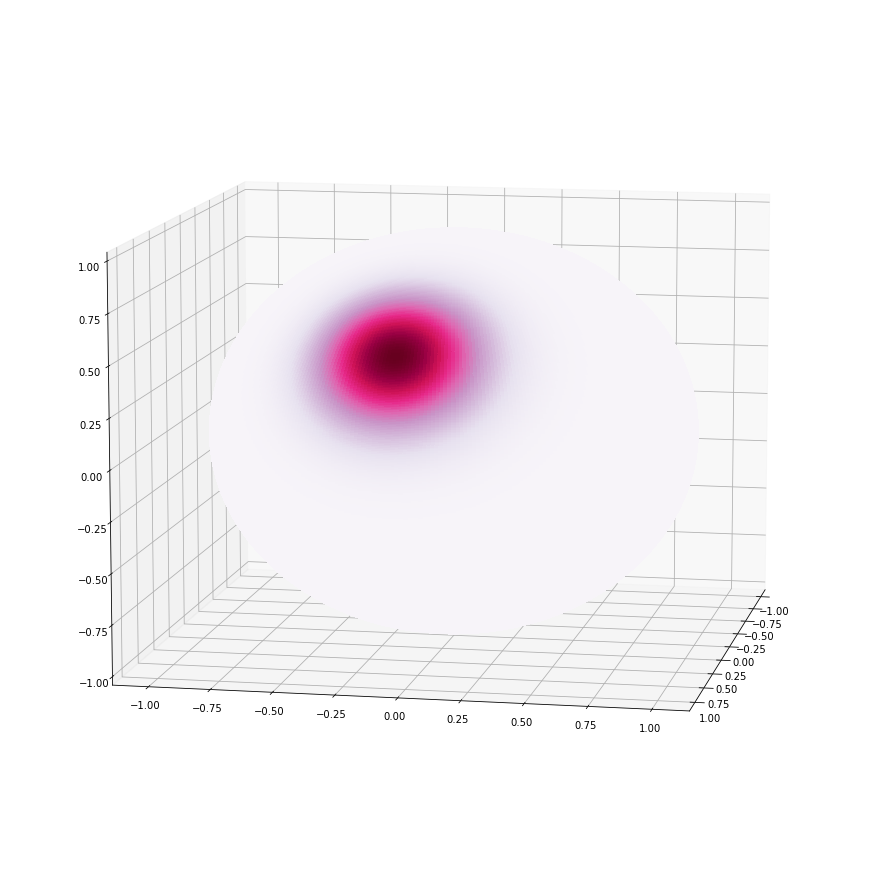

In [976]:
x,y,z = 0.7369956276605778, -0.06322684342628815,0.45283981107953863
lh = 0.3


distX = X-x
distY = Y-y
distZ = Z-z
dist = np.linalg.norm(np.array([distX,distY,distZ]),ord=2,axis=0)  

X0 = np.exp(- dist **2 / lh**2)

from matplotlib import colors, cm
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(elev=10., azim=11)

strength = X0
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.PuRd,
                       linewidth=0, antialiased=False,
                       facecolors=cm.PuRd(norm(strength)),zorder=1)

first we need to build a wind field on the sphere.

## generating a wind field on the sphere :

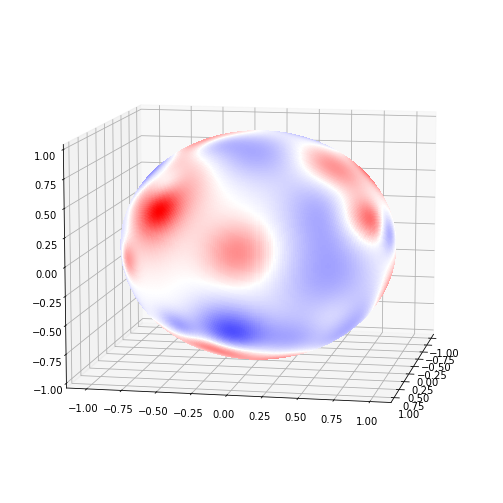

In [977]:
def random_field():
    n_points = 80
    random_field = np.zeros_like(X0)
    for i in range(n_points):
        vec = np.random.uniform(-1,1,3)
        vec = vec / np.linalg.norm(vec)

        x,y,z = vec

        distX = X-x
        distY = Y-y
        distZ = Z-z

        dist = np.linalg.norm(np.array([distX,distY,distZ]),ord=2,axis=0)  

        lh = np.random.uniform(0.15,0.4)
        sign = -1 if np.random.rand()<0.5 else 1
        random_field +=  np.exp(- dist **2 / lh**2) * sign
    return random_field

from matplotlib import colors, cm
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(elev=10., azim=11)

strength = random_field()
divnorm=colors.TwoSlopeNorm(vmin = np.min(strength),vmax = np.max(strength), vcenter=0)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.bwr,
                       linewidth=0, antialiased=False,
                       facecolors=cm.bwr(divnorm(strength)),zorder=1)

 18%|██████████████                                                                 | 427/2400 [00:40<01:48, 18.19it/s]

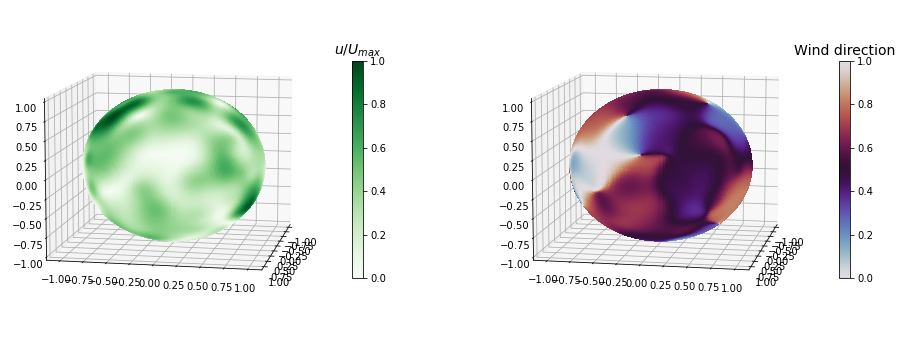

In [984]:
wind_1 = random_field()  #theta : parallel to the longitude : going down/up
wind_2 = random_field()  #1#np.cos(theta)  #phi : parallel to the latitude : going sideways


wind_theta = (wind_1.T[np.newaxis].T) * e_theta
wind_phi = (wind_2.T[np.newaxis].T) * e_phi#_norm

wind = np.array([wind_1, wind_2]) #theta, phi
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(1,2,1,projection='3d')
length = .025
ax.view_init(elev=10., azim=11)

ds = 1

strength = np.linalg.norm(np.array([wind_1, wind_2]),axis=0)
norm=colors.Normalize(vmin = 0, vmax = strength.max(), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.Greens,
                       linewidth=0, antialiased=False,
                       facecolors=cm.Greens(norm(strength)),zorder=-1)

cb = fig.colorbar(surface,ax=ax,shrink=0.25)
cb.ax.set_title(r"$u/U_{max}$",fontsize=14)

ax2 = fig.add_subplot(1,2,2,projection='3d')
length = .025
ax2.view_init(elev=10., azim=11)

ds = 1

strength = np.arctan2(*wind)
norm=colors.Normalize(vmin = -np.pi, vmax = np.pi, clip = False)

surface = ax2.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.twilight,
                       linewidth=0, antialiased=False,
                       facecolors=cm.twilight(norm(strength)),zorder=-1,vmin=-np.pi,vmax=np.pi)

cb = fig.colorbar(surface,ax=ax2,shrink=0.25)
cb.ax.set_title("Wind direction",fontsize=14)
plt.show()

In [985]:
wind = wind/np.linalg.norm(wind,axis=0).max()
max_wind_speed = 50 #kmh
D = 6370 #earth radius in km
wind = wind/D * max_wind_speed


In [986]:
def BilinearSpherical(thetad, phid, state):
    THETAd = THETA + (thetad-theta)/dtheta
    PHId  = PHI + (phid-phi)/dphi
    state = state.T
    weigth = np.cos(theta)/(np.cos(theta) + np.cos(np.roll(theta,-1,axis=1)))
    weigth = weigth*0+0.5
    interpolation = (1-THETAd%1)*(  (1-PHId%1) * state[THETAd.astype(int)       ,  PHId.astype(int)      ]
                                           + (PHId % 1) * state[THETAd.astype(int)       ,  (PHId+1).astype(int)%n] ) \
            +  (THETAd % 1) *(  (1-PHId%1) * state[(THETAd+1).astype(int)%n ,  PHId.astype(int)      ]
                                           + (PHId % 1) * state[(THETAd+1).astype(int)%n ,  (PHId+1).astype(int)%n] )
    
    return interpolation

In [987]:
def SphericalPeriodisation(thetad, phid):
    # apply the following corrections : (theta, +-pi +- espsilon) = (theta, -+pi +-epsilon)
    #                                   (pi/2 + espilon, phi) = (pi/2 - epsilon, phi + pi)
    
    indices = np.where(thetad>np.pi/2)
    epsilon = thetad[indices] - np.pi/2
    thetad[indices] = np.pi/2 - epsilon
    phid[indices] = phid[indices] + np.pi

    
    indices = np.where(thetad <-np.pi/2)
    epsilon = thetad[indices] + np.pi/2
    thetad[indices] = np.pi/2 + epsilon
    phid[indices] = phid[indices] + np.pi
    
    indices = np.where( phid>np.pi)
    phid[indices] -= 2*np.pi
    indices = np.where(phid<-np.pi)
    phid[indices] += 2*np.pi
    
    return thetad, phid

In [988]:
from mypackage.problem import Model

class SemiLagShericalAdv(Model):
    def _make_trend(self):
        wind_phi = self.trend_parameters[0]
        thetad = theta - self.dt*wind[0]
        phid = phi - self.dt*wind[1]
        self.thetad, self.phid = SphericalPeriodisation(thetad,phid)
        
    def _step(self, new_dt=None):
        self.x = BilinearSpherical(self.thetad, self.phid, self.x)
        #saving :
        self.t += self.dt
        if self.save and (self.time_saving_interval =="all"  or self.t - self.last_saved_time >= self.time_saving_interval) :
            self.saved_times.append(self.t)
            self.trajectory[self.t] = self.x
            self.last_saved_time = self.t

In [989]:
t_end = 600
dt = 0.25
SL = SemiLagShericalAdv(X0, dt=dt, trend_parameters=[wind],time_saving_interval=4)

SL.forecast(t_end)

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [02:02<00:00, 19.63it/s]


In [962]:
def index_img(index):
    if index < 10 :
        return '00'+str(index) 
    elif 10<= index < 100 :
        return '0'+str(index) 
    else:
        return index

In [ ]:
from tqdm import tqdm
path = '../../../Pictures/sphere_plot/'
angles = np.arctan2(wind_2,wind_1)
from sklearn.preprocessing import MinMaxScaler
angles = MinMaxScaler().fit_transform(angles)
angles[indices]
ds = 2
for i,(time, x) in tqdm(enumerate(zip(SL.saved_times,SL.trajectory.values()))):
    indices = np.where(X0[::ds,ds::]>0.01)
    
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(1,1,1,projection='3d')
    length = .005
    ax.view_init(elev=10., azim=11)

    strength = x
    norm=colors.Normalize(vmin = 0, vmax = 1, clip = False)

    surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.Greens,
                           linewidth=0, antialiased=False,
                           facecolors=cm.Greens(norm(strength)),zorder=-1,vmin=0,vmax=strength.max())
#     ax.quiver(*projection(OM[indices]), *projection((wind_phi+wind_theta)[indices]),
#               length=length, normalize=False,color='k',zorder=3,linewidth=0.5);
#     ax.quiver(*projection(OM[::ds,ds::][indices]), *projection((wind_phi+wind_theta)[::ds,ds::][indices]),
#               length=length, normalize=False,colors='k',zorder=3,linewidth=0.5);
    cb = fig.colorbar(surface,ax=ax,shrink=0.25)
    fig.savefig(path+str(index_img(i)))
    fig.clear()
    
    img = plt.imread(path+str(index_img(i))+".png")
    img= img[650:1100,490:1050]
    plt.imsave(path+str(index_img(i))+'.png',img)

In [999]:
import glob
from PIL import Image

fp_in = path +'*.png'
fp_out = 'animated_plots/'+'lol.gif'

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)


making the GIF file...


## Mass variation :

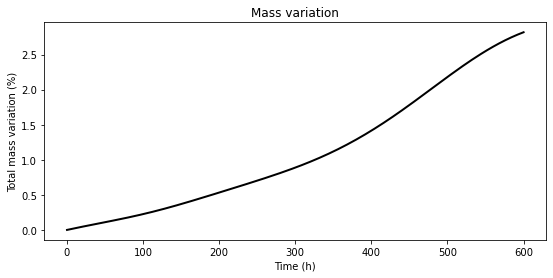

In [1000]:
traj = np.array(list(SL.trajectory.values()))
mass = traj.sum(axis=(1,2))
mass_variation = mass/mass[0] -1 
plt.figure(figsize=(9,4))
plt.plot(SL.saved_times,mass_variation,c='k',linewidth = 2 )
plt.title("Mass variation");
plt.ylabel("Total mass variation (%)")
plt.xlabel("Time (h)");